# Integration

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate as Int
import sympy as spy
import mpmath as mpm

In [2]:
spy.init_printing()

## Numerical Integration Methods

Here we are concerned with evaluating definite integrals on the form $I(f) = \int_{a}^{b}f(x)dx$, with given integration limits $a$ and $b$. The interval $[a, b]$ can be finite, semi-infinite (where either $a = -\infty$ or $b = \infty$), or infinite (where both $a = -\infty$ and $b = \infty$). The integral $I(f)$ can be interpreted as the area between the curve of the integrand $f(x)$ and the $x$ axis as shown bellow

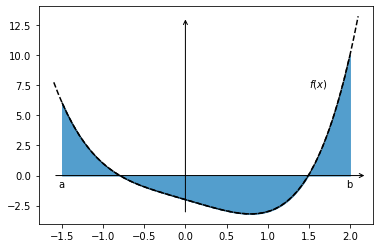

In [3]:
def f(x):
    return x**4-2*x -2


fig, ax = plt.subplots()
a=-1.5
b=2
x = np.linspace(a,b,51)
x1 = np.linspace(a-0.1,b+0.1,71)
y = f(x)
y1 = f(x1)

ax.plot(x,y,'k--')
ax.plot(x1,y1,'k--')

ax.fill_between(x, y, color='#539ecd')
ax.annotate("", xy=(x1.max()+0.1, 0), xytext=(x1.min(), 0),arrowprops=dict(arrowstyle="->"))
ax.annotate("", xy=(0,y1.max()-0.1,), xytext=(0,y1.min(),),arrowprops=dict(arrowstyle="->"))
ax.text(a-0.05, -1, "a", transform=ax.transData)
ax.text(b-0.05, -1, "b", transform=ax.transData)
ax.text(1.5, 7.4, "$f(x)$", transform=ax.transData)
fig.savefig('int.png', bbox_inches='tight')
plt.show()


A general strategy for numerically evaluating an integral $I(f)$, on the form given above, is to write the integral as a discrete sum that approximates the value of the integral:
\begin{equation}
I(f) = \sum_{1}^{n}w_if(x_i) + R_n
\end{equation}

Here w i are the weights of $n$ evaluations of $f(x)$ at the points $x_i \in [a, b]$, and $r_n$ is the residual due to the approximation. In practice we assume that $r_n$ is small and can be neglected, but it is important to have an estimate of $r_n$ to known how accurately the integral is approximated. This summation formula for $I(f)$ is known as an $n$-point __quadrature rule__, and the choice of the number of points $n$, their locations in $[a, b]$, and the weight factors $w_i$ influence the accuracy and the computational complexity
of its evaluation. Quadrature rules can be derived from interpolations of $f(x)$ on the interval $[a, b]$. If the points $x_i$ are evenly spaced in the interval $[a, b]$, and a polynomial interpolation is used, then the resulting quadrature rule is known as a __Newton-Cotes quadrature rule.__

Approximating $f(x)$ by a polynomial of degree one, evaluated at the endpoints of the interval, results in
\begin{equation}
\int_{a}^{b}f(x)dx\approx \frac{a+b}{2}\left(f(a)+f(b)\right).
\end{equation}

This is known as the __trapezoid rule__, and it is also of polynomial degree one. Using an
interpolation polynomial of second order results in __Simpson's rule__,
\begin{equation}
\int_{a}^{b}f(x)dx\approx \frac{a+b}{2}\left(f(a)+4f\left(\frac{a+b}{2}\right) + f(b)\right).
\end{equation}



The method of arriving at this formula can easily be demonstrated using SymPy: First we define symbols for the variables $a$, $b$, and $x$, as well as the function $f$.

In [4]:
f = spy.Function("f")

In [5]:
a, b, X = spy.symbols("a, b, x")

In [6]:
x = a, (a+b)/2, b  # for Simpson's rule

In [7]:
w = [spy.symbols("w_%d" % i) for i in range(len(x))]
w

Given $x$ and $w$, we can now construct a symbolic expression for the quadrature rule:

In [8]:
q_rule = sum([w[i] * f(x[i]) for i in range(len(x))])

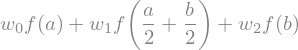

In [10]:
q_rule

To compute the appropriate values of the weight factors $w_i$, we choose the polynomial basis functions $$ \displaystyle \left\{ \phi_n(x) = x^n \right\}_{1}^{n}$$ for the interpolation of $f(x)$, and here we use $n =0$ the sympy.Lambda function to create symbolic representations for each of these basis functions:

In [11]:
ϕ = [spy.Lambda(X, X**n) for n in range(len(x))]

In [12]:
ϕ

 The key to finding the weight factors in the quadrature expression is that the integral $\int_{a}^{b}\phi(x)dx$ can be computed analytically for each of the basis functions $\phi(x)$.
 \begin{equation}
 \sum_{i=0}^{2}w_i\phi_n(x_i) = \int_{a}^{b} \phi_n(x)dx
 \end{equation}

By substituting the function $f(x)$ with each of the basis functions $\phi_n (x)$ in the quadrature
rule, we obtain an equation system for the unknown weight factors:

In [13]:
eqs = [q_rule.subs(f, ϕ[n]) - spy.integrate(ϕ[n](X), (X, a, b)) for n in range(len(ϕ))]

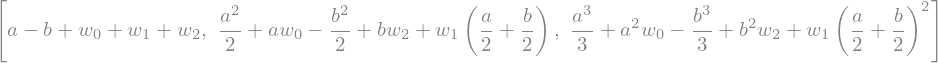

In [14]:
eqs

Solving this linear equation system gives analytical expressions for the weight factors,

In [15]:
w_sol = spy.solve(eqs, w)

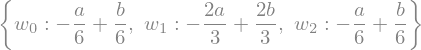

In [19]:
w_sol

and by substituting the solution into the symbolic expression for the quadrature rule, we obtain

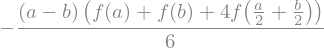

In [20]:
q_rule.subs(w_sol).simplify()

We recognize this result as Simpson's quadrature rule given in the preceding section.

Higher-order quadrature rules can similarly be derived using higher-order polynomial interpolation (more sample points in the $[a, b]$ interval). However, high-order polynomial interpolation can have undesirable behavior between the sample points. Rather than using higher-order quadrature rules, it is therefore often better to divide the integration interval $[a, b]$ into subintervals $[a = x_0 , x_1],[x_1 , x_2 ],\cdots,[x_{N-1} , x_N = b]$ and use a low-order quadrature rule in each of these subintervals. Such methods are known as composite quadrature rules.

### Numerical Integration with SciPy

The numerical quadrature routines in the SciPy integrate module can be categorized into two types: routines that take the integrand as a Python function and routines that take arrays with samples of the integrand at given points. The functions of the first type use __Gaussian quadrature__ (quad, quadrature, fixed_quad), while functions of the second type use __Newton-Cotes__ methods (trapz, simps, and romb).

### Gaussian Quadrature
As a concrete example, consider the numerical evaluation of the integral $\int_{-1}^{1}e^{-x^2}d x$ . To evaluate this integral using SciPy’s quad function, we first define a function for the integrand and then call the quad function:

In [18]:
import scipy.integrate as Int

In [19]:
def f(x):
    return np.exp(-x**2)

In [20]:
val, err = Int.quad(f, -1, 1)

In [21]:
val

In [22]:
err

The quad function returns a tuple that contains the numerical __estimate of the integral__, __val__, and an estimate of the __absolute error__, __err__. The tolerances for the absolute and the relative errors can be set using the optional __epsabs__ and __epsrel__ keyword arguments, respectively.

If the function $f$ takes more than one variable, the quad routine integrates the function over its first argument. We can optionally specify the values of additional arguments by passing those values to the integrand function via the keyword argument args to the quad function. For example, if we wish to evaluate 
\begin{equation}
\int_{-1}^{1}ae^{-(x - b )^2 /c^2} dx
\end{equation}
for the specific values of the parameters a = 1, b = 2, and c = 3, we can define a function
for the integrand that takes all these additional arguments and then specify the values of
a, b, and c by passing args=(1, 2, 3) to the quad function:

In [26]:
def f(x, a, b, c):
    return a*np.exp(-((x - b)/c)**2)

In [27]:
val, err = Int.quad(f, -1, 1, args=(1, 2, 3))

In [28]:
val

In [29]:
err

### Tabulated Integrand

In [25]:
f = lambda x: np.sqrt(x)
a, b = 0, 2

In [26]:
x = np.linspace(a, b, 25)
y =f(x)

In [27]:
x

array([0.        , 0.08333333, 0.16666667, 0.25      , 0.33333333,
       0.41666667, 0.5       , 0.58333333, 0.66666667, 0.75      ,
       0.83333333, 0.91666667, 1.        , 1.08333333, 1.16666667,
       1.25      , 1.33333333, 1.41666667, 1.5       , 1.58333333,
       1.66666667, 1.75      , 1.83333333, 1.91666667, 2.        ])

In [28]:
y

array([0.        , 0.28867513, 0.40824829, 0.5       , 0.57735027,
       0.64549722, 0.70710678, 0.76376262, 0.81649658, 0.8660254 ,
       0.91287093, 0.95742711, 1.        , 1.040833  , 1.08012345,
       1.11803399, 1.15470054, 1.19023807, 1.22474487, 1.25830574,
       1.29099445, 1.32287566, 1.3540064 , 1.38443731, 1.41421356])

Text(0, 0.5, '$f(x)$')

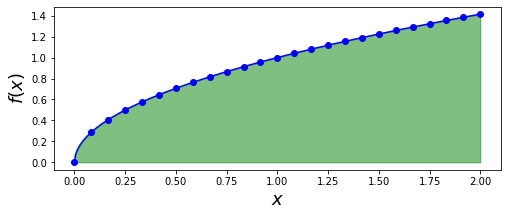

In [29]:
fig, ax = plt.subplots(figsize=(8, 3))
ax.plot(x, y, 'bo')
xx = np.linspace(a, b, 500)
ax.plot(xx, f(xx), 'b-')
ax.fill_between(xx, f(xx), color='green', alpha=0.5)
ax.set_xlabel(r"$x$", fontsize=18)
ax.set_ylabel(r"$f(x)$", fontsize=18)

In [30]:
val_trapz = Int.trapz(y, x)

In [32]:
val_trapz

In [33]:
val_simps = Int.simps(y, x)

In [34]:
val_simps

### Multiple Integration

For example, consider the integral 
\begin{equation}
\int_{0}^{1}\int_{0}^{1} e^{-x^2 - y^2} dx dy. 
\end{equation}
To evaluate this we first define the function f for the integrand and graph the function and the
integration region, as shown in the Figure below

In [35]:
def f(x, y):
    return np.exp(-x**2 - y**2)

Text(0, 0.5, '$y$')

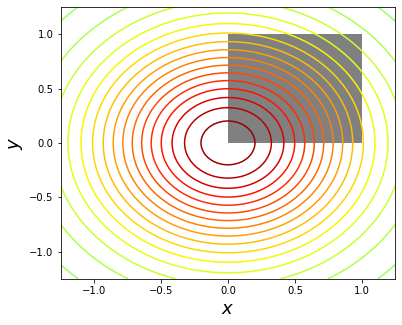

In [40]:
fig, ax = plt.subplots(figsize=(6, 5))
x = y = np.linspace(-1.25, 1.25, 75)
X, Y = np.meshgrid(x, y)
c = ax.contour(X, Y, f(X, Y), 15, cmap=mpl.cm.jet, vmin=-1,vmax=1)
bound_rect = plt.Rectangle((0, 0), 1, 1, facecolor="grey")
ax.add_patch(bound_rect)
ax.axis('tight')
ax.set_xlabel('$x$', fontsize=18)
ax.set_ylabel('$y$', fontsize=18)

In this example the integration limits for both the $x$ and $y$ variables are constants, but since __dblquad__ expects functions for the integration limits for the y variable, we must also define the functions h and g, even though in this case they only evaluate to constants regardless of the value of $x$.

In [36]:
a, b = 0, 1
g = lambda x: 0
h = lambda x: 1

Now, with all the arguments prepared, we can call __dblquad_ to evaluate the integral:

In [37]:
Int.dblquad(f, a, b, g, h)

Note that we could also have done the same thing a bit more concisely, although slightly less readable, by using _inline_ __lambda function__ definitions:

In [38]:
Int.dblquad(lambda x, y: np.exp(-x**2-y**2), 0, 1, lambda x: 0, lambda x: 1)

Because $g$ and $h$ are functions, we can compute integrals with x-dependent integration limits along the $y$ dimension. For example, with $g(x) = x -1$ and $h(x) = 1 -x$, we obtain:

In [39]:
Int.dblquad(f, 0, 1, lambda x: -1 + x, lambda x: 1 - x)

In [45]:
Int.tplquad?

## Ordinary Differential Equations

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate as Int
import sympy as spy

### First Order ODE
 __Initial value problem__: 
  Consider the first order ODE:
\begin{equation}
\frac{dy}{dt} = f(t,y), \qquad \text{with initial condition } y(0)=y_0
\end{equation}
 
 __Euler method__


The __explicity Euler's method__ is given by  approximating the derivative with the forward difference as
\begin{equation}
y_i^{\prime} = \frac{y_{i+1} - y_{i}}{h} + \mathcal{O}(h)
\end{equation}
which gives the approximate solution at node $i$ as. 
\begin{equation}
y_{i+1} = y_{i} + hf(t_i,y_i),
\end{equation}
where $h$ is the step size of the discretization.

Similarly, if we use the backward difference for approximation we get the __implicit Euler's method__ as 
\begin{equation}
y_{i+1} = y_{i} + hf(t_{i+1},y_{i+1})
\end{equation}



__Example__

Consider  $y^{\prime}=-y$  with a condition gives  $y(t) = y_0e^{-t} $

In [41]:
def f(t,y):
    return (-y)

In [43]:
def forwardEuler(a,b,h,y0,f):
    n = int((b-a)/h)
    t = np.linspace(a, b, n+1) # Discretization of the time variable
    y = np.empty(t.size)
    y[0]=y0                    # initial condition
    for n, T in enumerate(t[:-1]):
        y[n+1] = y[n] + h *f(T,y[n])
    return t,y

In [45]:
%matplotlib qt
a = 0
b =1
h=0.1
y0=1

t,y_app= forwardEuler(a,b,h,y0,f)
y_ext = np.exp(-t)

plt.plot(t, y_app, '-+', label='Explicit method')
plt.plot(t,y_ext , label='Exact solution')
plt.legend()
plt.show()

### Higher order methods

__One-Step Methods:__ __Runge-Kutta type__

 Most popular method is explicit RK4:
 \begin{equation}
 \begin{aligned}
 k_1 &= hf\left(t_n,y_n\right) \\
 k_2 &= hf\left(t_n + \frac{h}{2},y_n+\frac{k_1}{2}\right) \\
 k_3 &= hf\left(t_n + \frac{h}{2},y_n+\frac{k_2}{2}\right) \\
 k_4 &= hf\left(t_n + h,y_n+k_3\right)
 \end{aligned}
 \end{equation}

$y_{n+1} = y_n + \frac{1}{6}\left(k_1 + 2(k_2 + k_3) +k_4\right)$

In [46]:
def RK4(a,b,h,y0,f):
    n = int((b-a)/h)
    t = np.linspace(a, b, n+1) # Discretization of the time variable
    y = np.empty(t.size)
    y[0]=y0                    # initial condition
    for n, T in enumerate(t[:-1]):
        k1 = h*f(T,y[n])
        k2 = h*f(T +h/2,y[n]+ k1/2)
        k3 = h*f(T +h/2,y[n]+ k2/2)
        k4 = h*f(T +h,y[n]+ k3)
        
        y[n+1] = y[n] + (1/6)*(k1 + 2*(k2+k3) + k4)
    return t,y

In [48]:
%matplotlib qt
a = 0
b =1
h=0.1
y0=1

t,y_ex= forwardEuler(a,b,h,y0,f)
t,y_rk4 = RK4(a,b,h,y0,f)

plt.plot(t, y_ex, '-+', label='Explicit Euler')
plt.plot(t, y_rk4,'-or', label='RK4')
plt.plot(t, np.exp(-t), label='Exact solution')
plt.legend()
plt.show()

__Coupled ODE__

__The SIR Model for Spread of Disease - The Differential Equation Model__

In [50]:
def SIR(y,t,p):
    S,I,R = y # vector of state variable y=[S,I,R]
    b,k = p
    dSdt = -b*S*I
    dIdt = b*S*I - k*I
    dRdt = k*I
    f = [dSdt,dIdt,dRdt]
    return f    

In [55]:
# Initial Conditions
s0 = 1
i0 = 1.27e-6
r0 = 0
S0 = [s0,i0,r0]
#Parameters
b = 1/2
k = 1/5
p=[b,k]



t = np.linspace(0,140,140)

wsol = Int.odeint(SIR, S0, t, args=(p,) )

S=wsol[:,0]
I=wsol[:,1]
R=wsol[:,2]

plt.xlabel('t')
#plt.grid(True)
lw = 2

plt.plot(t, S, 'b', linewidth=lw)
plt.plot(t, I, 'g', linewidth=lw)
plt.plot(t, R, 'k', linewidth=lw)

plt.legend(('$S$', '$I$', '$R$'))
plt.title('')



Text(0.5, 1.0, '')

## Partial Differential Equations: The Finite Difference

__1D Wave Equation__

__Simulation of waves on a string__

We begin our study of wave equations by simulating one-dimensional waves on a string, say on a guitar or violin. Let the string in the deformed state coincide with the interval $ [0,L]$  on the $ x$ axis, and let $ u(x,t)$ be the displacement at time $ t $ in the $ y $ direction of a point initially at $ x$. The displacement function $u$ is governed by the mathematical model 
$$ 
\begin{align} 
u_{tt} &= c^2 u_{xx}, \quad & x\in (0,L),\ t\in (0,T] \tag{1}\\ 
u(x,0) &= I(x), \quad &x\in [0,L] \tag{2}\\
u_t(x,0) &= 0, \quad &x\in [0,L] \tag{3}\\ u(0,t) & = 0, \quad &t\in (0,T] \tag{4}\\
u(L,t) & = 0, \quad &t\in (0,T] \tag{5} 
\end{align} 
$$ The constant $c$ and the function $ I(x)$ must be prescribed. Equation (1) is known as the __one-dimensional wave equation__. 

Since this PDE contains a second-order derivative in time, we need two initial conditions. The condition (2) specifies the initial shape of the string, $I(x)$, and (3) expresses that the initial velocity of the string is zero. 

In addition, PDEs need boundary conditions, give here as (4) and (5). These two conditions specify that the string is fixed at the ends, i.e., that the displacement $ u $ is zero.

The solution $u(x,t)$ varies in space and time and describes waves that move with velocity $c $ to the left and right.

### Discretizing the domain

The PDE problem (1)-(5) will now be discretized in space and time by a finite difference method.

The temporal domain $[0,T]$ is represented by a finite number of mesh points 
\begin{equation} 
0 = t_0 < t_1 < t_2 < \cdots < t_{N_t-1} < t_{N_t} = T.\tag{7} 
\end{equation} 

Similarly, the spatial domain $[0,L]$ is replaced by a set of mesh points 
\begin{equation} 0 = x_0 < x_1 < x_2 < \cdots < x_{N_x-1} < x_{N_x} = L \tag{8} 
\end{equation} 
One may view the mesh as two-dimensional in the $(x,t)$ plane, consisting of points $(x_i, t_n)$, with $ i=0,\ldots,N_x $ and $n=0,\ldots,N_t $.


__Uniform meshes__

For uniformly distributed mesh points we can introduce the constant mesh spacings $\Delta t $ and $\Delta x $. We have that 
\begin{equation}
\begin{aligned}
x_i &= i\Delta x,\ i=0,\cdots,N_x,\\
t_n &= n\Delta t,\ n=0,\cdots,N_t 
\end{aligned} \tag{9}
\end{equation} 

We also have that $\Delta x = x_i-x_{i-1} $, $ i=1,\cdots,N_x $, and $ \Delta t = t_n - t_{n-1},  n=1,\cdots,N_t$. The Figure below displays a mesh in the \( x,t \) plane with $N_t=5$, $ N_x=5$, and constant mesh spacings.

In [59]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid()
ax.plot(2, 2, 'ko', lw=3)
ax.plot(2, 3, 'ko', lw=3)
ax.plot(1, 2, 'ko', lw=3)
ax.plot(3, 2, 'ko', lw=3)
ax.plot(2, 1, 'ko', lw=3)
ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

ax.set_xlabel('$index\; i$', fontsize=18)
ax.set_ylabel('$index\; n$', fontsize=18)

Text(0, 0.5, '$index\\; n$')

__The discrete solution__

The solution $u(x,t)$ is sought at the mesh points. We introduce the mesh function $u_i^n $, which approximates the exact solution at the mesh point $(x_i,t_n)$ for $ i=0,\ldots,N_x $ and $n=0,\ldots,N_t$. Using the finite difference method, we shall develop algebraic equations for computing the mesh function.

__Fulfilling the equation at the mesh points__

In the finite difference method, we relax the condition that (1) holds at all points in the space-time domain $(0,L)\times (0,T]$ to the requirement that the PDE is fulfilled at the interior mesh points only: 

\begin{equation} 
u_{tt}(x_i, t_n) = c^2u_{xx}(x_i, t_n), \tag{10} 
\end{equation}
for $i=1,\ldots,N_x-1$ and $n=1,\ldots,N_t$. For $ n=0$ we have the initial conditions $u=I(x)$ and $u_t=0$, and at the boundaries $i=0,N_x$ we have the boundary condition $u=0$.

__Replacing derivatives by finite differences__

The second-order derivatives can be replaced by central differences. The most widely used difference approximation of the second-order derivative is 
$$ u_{tt}(x_i,t_n)\approx \frac{u_i^{n+1} - 2u_i^n + u^{n-1}_i}{\Delta t^2}.$$
It is convenient to introduce the finite difference operator notation $$ [D_tD_t u]^n_i = \frac{u_i^{n+1} - 2u_i^n + u^{n-1}_i}{\Delta t^2}.$$ 

A similar approximation of the second-order derivative in the $x$ direction reads 
$$ u_{xx}(x_i,t_n)\approx \frac{u_{i+1}^{n} - 2u_i^n + u^{n}_{i-1}}{\Delta x^2} = [D_xD_x u]^n_i.$$

__Algebraic version of the PDE__

We can now replace the derivatives in (10) and get
\begin{equation} 
\frac{u_i^{n+1} - 2u_i^n + u^{n-1}_i}{\Delta t^2} = c^2\frac{u_{i+1}^{n} - 2u_i^n + u^{n}_{i-1}}{\Delta x^2}, \tag{11}
\end{equation}

or written more compactly using the operator notation: $$ \begin{equation} [D_tD_t u = c^2 D_xD_x]^{n}_i  \tag{12} \end{equation} $$

__Interpretation of the equation as a stencil__

A typical feature of (11) is that it involves $ u $ values from neighboring points only: $ u_i^{n+1} $, $ u^n_{i\pm 1}$, $ u^n_i $, and $ u^{n-1}_i $. The circles in the Figure illustrate such neighboring mesh points that contributes to an algebraic equation. In this particular case, we have sampled the PDE at the point $(2,2)$ and constructed (11), which then involves a coupling of $ u_2^1 $, $ u_1^2 $, $ u_2^2$, $u_3^2$, and $u_2^3 $. The term stencil is often used about the algebraic equation at a mesh point, and the geometry of a typical stencil is illustrated in Figure above. One also often refers to the algebraic equations as discrete equations, (finite) difference equations or a finite difference scheme.

__Algebraic version of the initial conditions__

We also need to replace the derivative in the initial condition (3) by a finite difference approximation. A centered difference of the type 
$$u_{tt}(x_i,t_n)\approx \frac{u^1_i - u^{-1}_i}{2\Delta t} = [D_{2t} u]^0_i, $$ 
seems appropriate. In operator notation the initial condition is written as 
$$ [D_{2t} u]^n_i = 0,\quad n=0. $$ 

Writing out this equation and ordering the terms give 
\begin{equation} 
u^{n-1}_i=u^{n+1}_i,\quad i=0,\ldots,N_x,\ n=0.\tag{13} 
\end{equation}  
The other initial condition can be computed by $$ u_i^0 = I(x_i),\quad i=0,\ldots,N_x$$


__Formulating a recursive algorithm__

We assume that $ u^n_i $ and $u^{n-1}_i$ are already computed for $i=0,\ldots,N_x$. The only unknown quantity in (11) is therefore $u^{n+1}_i$, which we can solve for: 
\begin{equation} 
u^{n+1}_i = -u^{n-1}_i + 2u^n_i + C^2 \left(u^{n}_{i+1}-2u^{n}_{i} + u^{n}_{i-1}\right), \tag{14} 
\end{equation}  where we have introduced the parameter
\begin{equation} 
C = c\frac{\Delta t}{\Delta x}, \tag{15}
\end{equation} known as the __Courant number__.

$C$ is the key parameter in the discrete wave equation. We see that the discrete version of the PDE features only one parameter, $ C $, which is therefore the key parameter that governs the quality of the numerical solution. Both the primary physical parameter $c$ and the numerical parameters $\Delta x $ and $\Delta t $ are lumped together in $C$. Note that $C$ is a dimensionless parameter.

Given that $u^{n-1}_i$ and $u^n_i$ are computed for $ i=0,\ldots,N_x$, we find new values at the next time level by applying the formula (14) for $ i=1,\ldots,N_x-1 $. The above Figure illustrates the points that are used to compute $u^3_2$. For the boundary points, $i=0$ and $i=N_x$, we apply the boundary conditions $u_i^{n+1}=0$.

A problem with (14) arises when $n=0 $since the formula for $u^1_i$ involves $u^{-1}_i$, which is an undefined quantity outside the time mesh (and the time domain). However, we can use the initial condition (13) in combination with (14) when $ n=0$ to eliminate $u^{-1}_i$ and arrive at a special formula for $u_i^1$: 
\begin{equation} 
u_i^1 = u^0_i - \frac{1}{2} C^2\left(u^{0}_{i+1}-2u^{0}_{i} + u^{0}_{i-1}\right).  \tag{16} 
\end{equation} The Figure bellow illustrates how (16) connects four instead of five points: $ u^1_2 $, $u_1^0$, $u_2^0$, and $u_3^0$.

In [60]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.grid()
ax.plot(2, 0, 'ko', lw=3)
ax.plot(1, 0, 'ko', lw=3)
ax.plot(2, 1, 'ko', lw=3)
ax.plot(3, 0, 'ko', lw=3)

ax.set_xlim([0, 5])
ax.set_ylim([-0.1, 5])

ax.set_xlabel('$index\; i$', fontsize=18)
ax.set_ylabel('$index\; n$', fontsize=18)

Text(0, 0.5, '$index\\; n$')

We can now summarize the computational algorithm:
<ol>
    <li> Compute $u^0_i=I(x_i)$ for $i=0,\ldots,N_x$</li>
    <li>Compute $u^1_i$ by (16) and set $u_i^1=0$ for the boundary points $i=0$ and $i=N_x$, for $ n=1,2,\ldots,N-1 $,</li>
    <li>For each time level $ n=1,2,\ldots,N_t-1 $
    <ol>
        <li>apply (14) to find \( u^{n+1}_i \) for \( i=1,\ldots,N_x-1 \)</li>
        <li>set \( u^{n+1}_i=0 \) for the boundary points \( i=0 \), \( i=N_x \).</li>
        </ol>
    </li>
</ol>
The algorithm essentially consists of moving a finite difference stencil through all the mesh points, which can be seen as an animation in a web page or a movie file.


In [59]:
import numpy as np

def solver(I,c, L, dt, C, T):
    """Solve u_tt=c^2*u_xx  on (0,L)x(0,T]."""
    Nt = int(round(T/dt))
    t = np.linspace(0, Nt*dt, Nt+1)   # Mesh points in time
    dx = dt*c/float(C)
    Nx = int(round(L/dx))
    x = np.linspace(0, L, Nx+1)       # Mesh points in space
    C2 = C**2                      # Help variable in the scheme
    
    u   = np.zeros(Nx+1)   # Solution array at new time level
    u_1 = np.zeros(Nx+1)   # Solution at 1 time level back
    u_2 = np.zeros(Nx+1)   # Solution at 2 time levels back
    U = np.zeros((Nx+1,Nt))
   

    # Load initial condition into u_1
    for i in range(0,Nx+1):
        u_1[i] = I(x[i])
    U[:,0]=u_1

    # Special formula for first time step
    n = 0
    for i in range(1, Nx):
        u[i] = u_1[i]  + 0.5*C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1])
               
    u[0] = 0;  u[Nx] = 0 # Boundary Conditions

    U[:,1] = u
    # Switch variables before next step
    u_2[:] = u_1;  
    u_1[:] = u
    
    for n in range(2, Nt):
        # Update all inner points at time t[n+1]
        for i in range(1, Nx):
            u[i] = - u_2[i] + 2*u_1[i] + C2*(u_1[i-1] - 2*u_1[i] + u_1[i+1]) 
           
        # Insert boundary conditions
        u[0] = 0;  u[Nx] = 0
        # Switch variables before next step
        u_2[:] = u_1;  u_1[:] = u
        U[:,n] = u
    return x, t, U

Many wave problems feature sinusoidal oscillations in time and space. For example, the original PDE problem (1)-(5) allows an exact solution $$ \begin{equation} u_{ex}(x,t)) = A\sin\left(\frac{\pi}{L}x\right) \cos\left(\frac{\pi}{L}ct\right) \end{equation} $$ 
This $u_{ex} $ fulfills the PDE with, boundary conditions $u_{ex}(0,t)=u_{ex}(L,0)=0 $, as well as initial conditions $ I(x)=A\sin\left(\frac{\pi}{L}x\right)$ 

In [60]:
def U_ex(A,c,L,x,t):
    return A*np.sin((np.pi/L)*x)*np.cos((np.pi/L)*c*t)


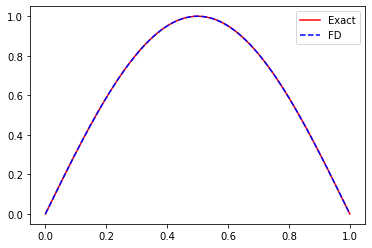

In [61]:
%matplotlib inline
T = 5
dt =0.001
L=1
c=1
C=0.5
A = 1
I = lambda x: A*np.sin((np.pi/L)*x)


Nt = len(t)
Nx = len(x)
u_ex = np.zeros((Nx,Nt))

x,t,u_app = solver(I,c, L, dt, C, T)


for i in range(Nt):
    u_ex[:,i] = U_ex(A,c,L,x,t[i])

plt.plot(x,u_ex[:,2],'-r')   
plt.plot(x,u_app[:,2],'--b')    
plt.legend(['Exact','FD'])
plt.show()

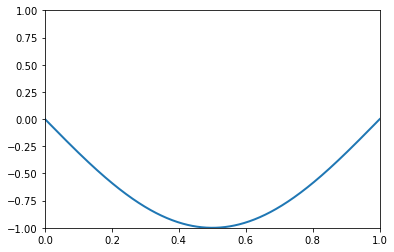

In [71]:
from matplotlib import animation, rc
from IPython.display import HTML


fig = plt.figure()
ax = plt.axes(xlim=(0, 1), ylim=(-1, 1))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,
# animation function.  This is called sequentially

def animate(i):
    x1 = x
    y = u_app[:,i]
    line.set_data(x1, y)
    return line,
# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(u_app[0,:]), interval=10, blit=True)


anim.save('basic_animation.mp4', fps=30, extra_args=['-vcodec', 'libx264'])

HTML(anim.to_html5_video())